### Customize your own GPU Kernels in gQuant

The gQuant is designed to accelerate quantitive finance workflows on the GPU. The acceleration on GPU is facilitated by using cuDF dataframes in the computation graph. The cuDF project is a continously evolving library that provides a pandas-like API. Sometimes, the data scientists are facing a few challenges that cannot be easily solved:
    1. The quantitative work needs customized logic to manipulate the data, and there are no direct methods within cuDF to support this logic.
    2. Each cuDF dataframe method call launches the GPU kernel once. For performance crtical task, it is sometimes required to wrap lots of computation steps together in a single GPU kernel to reduce the kernel launch overheads. 
The solution is to build customized GPU kernels to implement them. The code and examples below illustrate a variety of approaches to implement customized GPU kernels in Python.

In [1]:
import sys
sys.path.append('..')

# Load necessary Python modules
import sys
from gquant.dataframe_flow import TaskGraph, Node
import cudf
import numpy as np
from numba import cuda
import cupy
import math
import dask
import dask_cudf

Define a utility function to verify the results:

In [2]:
def verify(ground_truth, computed):
    max_difference = (ground_truth - computed).abs().max()
    # print('Max Difference: {}'.format(max_difference))
    assert(max_difference < 1e-8)
    return max_difference

### Example Problem: Calculating the distance of points to the origin

The sample problem is to take a list of points in 2-D space and compute their distance to the origin.
We start by creating a source `Node` in the graph that generate a cuDF dataframe containing 1000 random points.

In [3]:
class PointNode(Node):

    def columns_setup(self,):
        self.required = {}
        self.addition = {'x': 'float64',
                         'y': 'float64'}

    def process(self, inputs):
        df = cudf.DataFrame()
        df['x'] = np.random.rand(1000)
        df['y'] = np.random.rand(1000)
        return df

The distance can be computed via cuDF methods. We define the DistanceNode to calculate the distance and add a `distance_cudf` column to the output dataframe. We use that as the ground truth to compare and verify results later.

In [4]:
class DistanceNode(Node):

    def columns_setup(self,):
        self.required = {'x': 'float64',
                         'y': 'float64'}
        self.addition = {'distance_cudf': 'float64'}

    def process(self, inputs):
        df = inputs[0]
        df['distance_cudf'] = (df['x']**2 + df['y']**2).sqrt()
        return df

Having these two nodes, we can construct a simple task graph to compute the distance.

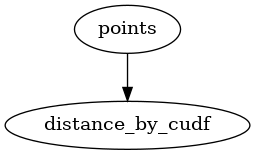

In [5]:
input_node = {
    'id': 'points',
    'type': PointNode,
    'conf': {},
    'inputs': []}

cudf_distance_node = {
    'id': 'distance_by_cudf',
    'type': DistanceNode,
    'conf': {},
    'inputs': ['points']}

task_list = [input_node, cudf_distance_node]
task_graph = TaskGraph(task_list)
task_graph.draw(show='ipynb')

The next step is to run the task graph to obtain the distances. The output is identified by the `id` of the distance node:

In [6]:
(out_df,) = task_graph.run(outputs=['distance_by_cudf'])
print(out_df)

            x         y  distance_cudf
0    0.836387  0.957514       1.271368
1    0.294106  0.109366       0.313782
2    0.495487  0.440543       0.663013
3    0.998370  0.553888       1.141724
4    0.691739  0.253014       0.736559
5    0.000852  0.061719       0.061725
6    0.765695  0.470009       0.898441
7    0.170214  0.214503       0.273833
8    0.567862  0.188615       0.598367
9    0.128882  0.536904       0.552157
10   0.752010  0.497383       0.901615
11   0.027600  0.129488       0.132397
12   0.714133  0.242321       0.754126
13   0.051390  0.874764       0.876272
14   0.424406  0.113438       0.439304
15   0.587216  0.961709       1.126812
16   0.478085  0.133467       0.496366
17   0.363664  0.157096       0.396145
18   0.624918  0.109936       0.634514
19   0.581437  0.400406       0.705970
20   0.961781  0.454890       1.063931
21   0.907983  0.740077       1.171387
22   0.408558  0.849442       0.942587
23   0.949032  0.475539       1.061508
24   0.212582  0.999529  

### Customized Kernel with Numba library

Numba is an excellent python library used for accelerating numerical computations. Numba supports CUDA GPU programming by directly compiling a restricted subset of Python code into CUDA kernels and device functions. The Numba GPU kernel is written in Python and translated (JIT just-in-time compiled) into GPU code at runtime. This is achieved by decorating a Python function with `@cuda.jit`. 

In [7]:
@cuda.jit
def distance_kernel(x, y, distance, array_len):
    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if ii < array_len:
        distance[ii] = math.sqrt(x[ii]**2 + y[ii]**2)

Just like a C/C++ CUDA GPU kernel, the `distance_kernel` function is called by thousands of threads in the GPU. The thread id is computed by `threadIdx.x`, `blockId.x` and `blockDim.x` built-in variables. Please check the [CUDA programming guild](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#thread-hierarchy) for details.

A cuDF series can be converted to GPU arrays compatible with the Numba library via `to_gpu_array` API. The next step is to define a Node that calls this Numba kernel to compute the distance and save the result into `distance_numba` column in the output dataframe.

In [8]:
class NumbaDistanceNode(Node):

    def columns_setup(self,):
        self.required = {'x': 'float64',
                         'y': 'float64'}
        self.addition = {'distance_numba': 'float64'}
        self.delayed_process = True

    def process(self, inputs):
        df = inputs[0]
        number_of_threads = 16
        number_of_blocks = ((len(df) - 1)//number_of_threads) + 1
        # Inits device array by setting 0 for each index.
        # df['distance_numba'] = 0.0
        # darr = rmm.device_array(len(df))
        darr = cuda.device_array(len(df))
        distance_kernel[(number_of_blocks,), (number_of_threads,)](
            df['x'].to_gpu_array(),
            df['y'].to_gpu_array(),
            darr,
            len(df))
        # df['distance_numba'].to_gpu_array()
        df['distance_numba'] = darr
        return df

The `self.delayed_process = True` flag in the `columns_setup` is necesary to enable the logic in the `Node` class for handling `dask_cudf` dataframes in order to use Dask (for distributed computation i.e. multi-gpu in examples later on). The `dask_cudf` dataframe does not support GPU customized kernels directly. The `to_delayed` and `from_delayed` low level interfaces of `dask_cudf` enable this support. The gQuant framework handles `dask_cudf` dataframes automatically under the hood when we set this flag.

### Customized Kernel by CuPy library

CuPy is an alternative to Numba. Numba JIT compiles Python code into GPU device code at runtime. There are some limitations in how Numba can be used as well as JIT compilation latency overhead. When a Python process calls a Numba GPU kernel for the first time Numba has to compile the Python code, and each time a new Python process is started the GPU kernel has to be recompiled. If advanced features of CUDA are needed and latency is important, CuPy is an alternative library that can be used to compile C/C++ CUDA code. CuPy caches the GPU device code on disk (default location `$(HOME)/.cupy/kernel_cache` which can be changed via `CUPY_CACHE_DIR` environment variable) thus eliminating compilation latency for subsequent Python processes.

`CuPy` GPU kernel is esentially a C/C++ GPU kernel. Below we define the `compute_distance` kernel using `CuPy`:

In [9]:
raw_kernel = cupy.RawKernel(r'''
    extern "C" __global__
    void compute_distance(const double* x, const double* y,
            double* distance, int arr_len) {
        int tid = blockDim.x * blockIdx.x + threadIdx.x;
        if (tid < arr_len){
        distance[tid] = sqrt(x[tid]*x[tid] + y[tid]*y[tid]);
        }
    }
''', 'compute_distance')

Using gQuant we can now define a Node that calls this CuPy kernel to compute the distance and save the results into `distance_cupy` column of a `cudf` dataframe.

In [10]:
class CupyDistanceNode(Node):

    def columns_setup(self,):
        self.required = {'x': 'float64',
                         'y': 'float64'}
        self.addition = {'distance_cupy': 'float64'}
        self.delayed_process = True

    def process(self, inputs):
        df = inputs[0]
        # cupy_x = cupy.asarray(df['x'].to_gpu_array())
        # cupy_y = cupy.asarray(df['y'].to_gpu_array())
        cupy_x = cupy.asarray(df['x'])
        cupy_y = cupy.asarray(df['y'])
        number_of_threads = 16
        number_of_blocks = (len(df) - 1)//number_of_threads + 1
        dis = cupy.ndarray(len(df), dtype=cupy.float64)
        raw_kernel((number_of_blocks,), (number_of_threads,),
                   (cupy_x, cupy_y, dis, len(df)))
        df['distance_cupy'] = dis
        return df

The `self.delayed_process = True` flag is added for the same reason as with `DistanceNumbaNode` i.e. to support `dask_cudf` data frames.

### Computing using the Nodes with customized GPU kernels

First we construct the computation graph for gQuant.

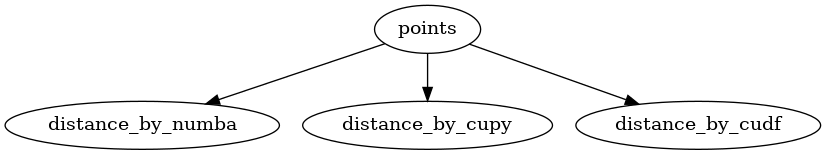

In [11]:
numba_distance_node = {
    'id': 'distance_by_numba',
    'type': NumbaDistanceNode,
    'conf': {},
    'inputs': ['points']
}

cupy_distance_node = {
    'id': 'distance_by_cupy',
    'type': CupyDistanceNode,
    'conf': {},
    'inputs': ['points']
}

task_list = [input_node, numba_distance_node,
             cupy_distance_node, cudf_distance_node]
out_list = ['distance_by_numba', 'distance_by_cupy', 'distance_by_cudf']
task_graph = TaskGraph(task_list)
task_graph.draw(show='ipynb')

Then we run the tasks.

In [12]:
df_w_numba, df_w_cupy, df_w_cudf = task_graph.run(out_list)

Use `verify` function defined above to verify the results:

In [13]:
mdiff = verify(df_w_cudf['distance_cudf'], df_w_numba['distance_numba'])
print('Max Difference: {}'.format(mdiff))
mdiff = verify(df_w_cudf['distance_cudf'], df_w_cupy['distance_cupy'])
print('Max Difference: {}'.format(mdiff))

Max Difference: 2.220446049250313e-16
Max Difference: 2.220446049250313e-16


### Dask distributed computation

Using Dask and `dask-cudf` we can run the Nodes with customized GPU kernels on distributed dataframes. Under the hood of the `Node` class the Dask delayed processing API is handled for cudf dataframes when the `self.delayed_process = True` flag is set.

We first start a distributed Dask environment. When a dask client is instantiated it registers itself as the default Dask scheduler (<http://distributed.dask.org/en/latest/client.html>). Therefore all subsequent Dask distibuted dataframe operations will run in distributed fashion.

In [14]:
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:45147 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 540.95 GB


The Dask status page can be displayed in a web browser at `<ip-address>:8787`. The ip-address corresponds to the machine where the dask cluster (scheduler) was launched. Most likely same ip-address as where this jupyter notebook is running. The javascript cell below will launch the dask status page otherwise manually go to the status page <http://distributed.dask.org/en/latest/web.html>. Using the Dask status page is convenient for monitoring dask distributed processing.

In [15]:
from IPython.display import HTML
javascript = """
<script type="text/Javascript">
    function check_status(){
        var url = document.location.href;
        var index = url.indexOf(':8888');
        var status = url.substr(0, index)+":8787";
        window.open(status,'_blank');
    }
    check_status();
</script>
"""
HTML(javascript)

The next step is to partition the `cudf` dataframe into a `dask_cudf` dataframe. Here we make the number of partitions correspond to the number of workers:

In [16]:
class DistributedNode(Node):

    def columns_setup(self,):
        self.required = {'x': 'float64',
                         'y': 'float64'}

    def process(self, inputs):
        npartitions = self.conf['npartitions']
        df = inputs[0]        
        return dask_cudf.from_cudf(df, npartitions=npartitions)

We add this distribution node to the computation graph to convert `cudf` dataframes into `dask-cudf` dataframes.

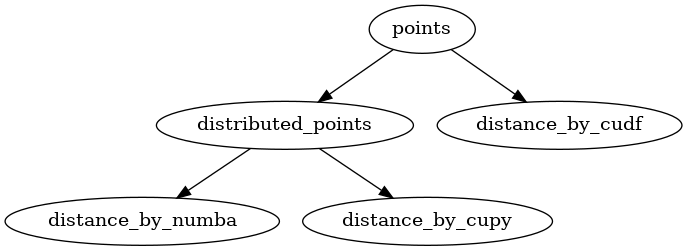

In [17]:
npartitions = len(client.scheduler_info()['workers'])

input_node = {
    'id': 'points',
    'type': PointNode,
    'conf': {},
    'inputs': []
}

distributed_node = {
    'id': 'distributed_points',
    'type': DistributedNode,
    'conf': {'npartitions': npartitions},
    'inputs': ["points"]
}

cudf_distance_node = {
    'id': 'distance_by_cudf',
    'type': DistanceNode,
    'conf': {},
    'inputs': ['points']
}

numba_distance_node = {
    'id': 'distance_by_numba',
    'type': NumbaDistanceNode,
    'conf': {},
    'inputs': ['distributed_points']
}

cupy_distance_node = {
    'id': 'distance_by_cupy',
    'type': CupyDistanceNode,
    'conf': {},
    'inputs': ['distributed_points']
}

task_list = [input_node, distributed_node, cudf_distance_node,
             numba_distance_node, cupy_distance_node]
out_list = ['distance_by_numba', 'distance_by_cupy', 'distance_by_cudf']
task_graph = TaskGraph(task_list)
task_graph.draw(show='ipynb')

In [18]:
df_w_numba, df_w_cupy, df_w_cudf = task_graph.run(out_list)
df_w_numba = df_w_numba.compute()
df_w_cupy = df_w_cupy.compute()

Verify the results:

In [19]:
mdiff = verify(df_w_cudf['distance_cudf'], df_w_numba['distance_numba'])
print('Max Difference: {}'.format(mdiff))
mdiff = verify(df_w_cudf['distance_cudf'], df_w_cupy['distance_cupy'])
print('Max Difference: {}'.format(mdiff))

Max Difference: 2.220446049250313e-16
Max Difference: 2.220446049250313e-16


One limitation to be aware of when using customized kernels within Nodes in the Dask environment, is that each GPU kernel works on one partition of the dataframe. Therefore if the computation depends on other partitions of the dataframe the approach above does not work.

### Saving Custom Nodes and Kernels

The gQuant framework already implements a number of Nodes. These can be found in `gquant.plugin_nodes` submodules. Refer to those nodes for reference implementations. For example:

In [20]:
import inspect
from gquant.plugin_nodes.dataloader import CsvStockLoader

print(inspect.getsource(CsvStockLoader))

class CsvStockLoader(Node):

    def columns_setup(self):
        self.required = {}
        self.addition = {"datetime": "date",
                         "asset": "int64",
                         "volume": "float64",
                         "close": "float64",
                         "open": "float64",
                         "high": "float64",
                         "low": "float64"}
        self.deletion = None
        self.retention = None

    def process(self, inputs):
        """
        Load the end of day stock CSV data into cuDF dataframe

        Arguments
        -------
         inputs: list
             empty list
        Returns
        -------
        cudf.DataFrame
        """

        df = pd.read_csv(self.conf['path'],
                         converters={'DTE': lambda x: pd.Timestamp(str(x))})
        df = df[['DTE', 'OPEN',
                 'CLOSE', 'HIGH',
                 'LOW', 'SM_ID', 'VOLUME']]
        df['VOLUME'] /= 1000
        output = cudf.from_pan

The customized kernels and nodes can be saved to your own python modules for future re-use instead of having to re-define them at runtime. We will take the nodes we defined above and write them to a python module. Then we will re-run our workflow importing the Nodes from the custom module we wrote out.

In [21]:
%%writefile custom_nodes.py

import math
import numpy as np
from numba import cuda
import cupy
import cudf
import dask_cudf

from gquant.dataframe_flow import Node
# from librmm_cffi import librmm as rmm


class PointNode(Node):

    def columns_setup(self,):
        self.required = {}
        self.addition = {'x': 'float64',
                         'y': 'float64'}

    def process(self, inputs):
        df = cudf.DataFrame()
        df['x'] = np.random.rand(1000)
        df['y'] = np.random.rand(1000)
        return df


class DistanceNode(Node):

    def columns_setup(self,):
        self.required = {'x': 'float64',
                         'y': 'float64'}
        self.addition = {'distance_cudf': 'float64'}

    def process(self, inputs):
        df = inputs[0]
        df['distance_cudf'] = (df['x']**2 + df['y']**2).sqrt()
        return df


@cuda.jit
def distance_kernel(x, y, distance, array_len):
    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if ii < array_len:
        distance[ii] = math.sqrt(x[ii]**2 + y[ii]**2)


class NumbaDistanceNode(Node):

    def columns_setup(self,):
        self.required = {'x': 'float64',
                         'y': 'float64'}
        self.addition = {'distance_numba': 'float64'}
        self.delayed_process = True

    def process(self, inputs):
        df = inputs[0]
        number_of_threads = 16
        number_of_blocks = ((len(df) - 1)//number_of_threads) + 1
        # Inits device array by setting 0 for each index.
        # df['distance_numba'] = 0.0
        darr = cuda.device_array(len(df))
        distance_kernel[(number_of_blocks,), (number_of_threads,)](
            df['x'].to_gpu_array(),
            df['y'].to_gpu_array(),
            darr,
            len(df))
        df['distance_numba'] = darr
        return df


raw_kernel = cupy.RawKernel(r'''
    extern "C" __global__
    void compute_distance(const double* x, const double* y,
            double* distance, int arr_len) {
        int tid = blockDim.x * blockIdx.x + threadIdx.x;
        if (tid < arr_len){
        distance[tid] = sqrt(x[tid]*x[tid] + y[tid]*y[tid]);
        }
    }
''', 'compute_distance')


class CupyDistanceNode(Node):

    def columns_setup(self,):
        self.required = {'x': 'float64',
                         'y': 'float64'}
        self.addition = {'distance_cupy': 'float64'}
        self.delayed_process = True

    def process(self, inputs):
        df = inputs[0]
        # cupy_x = cupy.asarray(df['x'].to_gpu_array())
        # cupy_y = cupy.asarray(df['y'].to_gpu_array())
        cupy_x = cupy.asarray(df['x'])
        cupy_y = cupy.asarray(df['y'])
        number_of_threads = 16
        number_of_blocks = ((len(df) - 1)//number_of_threads) + 1
        dis = cupy.ndarray(len(df), dtype=cupy.float64)
        raw_kernel((number_of_blocks,), (number_of_threads,),
                   (cupy_x, cupy_y, dis, len(df)))
        df['distance_cupy'] = dis
        return df


class DistributedNode(Node):

    def columns_setup(self,):
        self.required = {'x': 'float64',
                         'y': 'float64'}

    def process(self, inputs):
        npartitions = self.conf['npartitions']
        df = inputs[0]
        return dask_cudf.from_cudf(df, npartitions=npartitions)


Overwriting custom_nodes.py


When defining the tasks we specify `filepath` for the path to the python module that has the Node definition. Notice, that the `type` is specified as a string instead of class. The string is the class name of the node that will be imported for running a task.

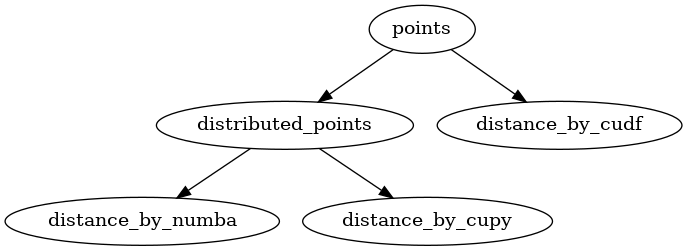

In [23]:
npartitions = len(client.scheduler_info()['workers'])

input_node = {
    'id': 'points',
    'type': 'PointNode',
    'conf': {},
    'inputs': [],
    'filepath': 'custom_nodes.py'
}

distributed_node = {
    'id': 'distributed_points',
    'type': 'DistributedNode',
    'conf': {'npartitions': npartitions},
    'inputs': ['points'],
    'filepath': 'custom_nodes.py'
}

cudf_distance_node = {
    'id': 'distance_by_cudf',
    'type': 'DistanceNode',
    'conf': {},
    'inputs': ['points'],
    'filepath': 'custom_nodes.py'
}

numba_distance_node = {
    'id': 'distance_by_numba',
    'type': 'NumbaDistanceNode',
    'conf': {},
    'inputs': ['distributed_points'],
    'filepath': 'custom_nodes.py'
}

cupy_distance_node = {
    'id': 'distance_by_cupy',
    'type': 'CupyDistanceNode',
    'conf': {},
    'inputs': ['distributed_points'],
    'filepath': 'custom_nodes.py'
}

task_list = [input_node, distributed_node, cudf_distance_node,
             numba_distance_node, cupy_distance_node]
out_list = ['distance_by_numba', 'distance_by_cupy', 'distance_by_cudf']
task_graph = TaskGraph(task_list)
task_graph.draw(show='ipynb')

In [24]:
df_w_numba, df_w_cupy, df_w_cudf = task_graph.run(out_list)
df_w_numba = df_w_numba.compute()
df_w_cupy = df_w_cupy.compute()

mdiff = verify(df_w_cudf['distance_cudf'], df_w_numba['distance_numba'])
print('Max Difference: {}'.format(mdiff))
mdiff = verify(df_w_cudf['distance_cudf'], df_w_cupy['distance_cupy'])
print('Max Difference: {}'.format(mdiff))

Max Difference: 2.220446049250313e-16
Max Difference: 2.220446049250313e-16


### Conclusion

Using customized GPU kernels allows data scientists to implement and incorporate advanced algorithms. We demonstrated implementations using Numba and CuPy.

The Numba approach enables data scientists to write GPU kernels directly in the Python language. Numba is easy to use for implementing and accelerating computations. However there is some overhead incurred for compiling the kernels whenever the Numba GPU kernels are used for the first time in a Python process. Currently Numba library only supports primitive data types. Some advanced CUDA programming features, such as function pointers and function recursions are not supported. 

The Cupy method is very flexible, because data scientists are writing C/C++ GPU kernels with CUDA directly. All the CUDA programming features are supported. CuPy compiles the kernel and caches the device code to the filesystem. The launch overhead is low. Also, the GPU kernel is built statically resulting in runtime efficiency. However it might be harder for data scientists to use, because C/C++ programming is more complicated. 

Below is a brief summary comparison table:

| Methods | Development Difficulty | Flexibility | Efficiency | Latency |
|---|---|---|---|---|
| Numba method | medium | medium | low | high |
| CuPy method | hard | high  | high | low |

We recommend that the data scientists select the approach appropriate for their task taking into consideration the efficiency, latency, difficulty and flexibility of their workflow. 

In this blog, we showed how to wrap the customized GPU kernels in gQuant nodes. Also, by taking advantage of having the gQuant handle the low-level Dask interfaces for the developer, we demonstrated how to use the gQuant workflow with Dask distributed computations.

In [25]:
# Clean up

# Shutdown the Dask cluster
client.close()
cluster.close()